## Our Revised Strategy for Deep Learning (CNN & Transfer Learning):

Someone also tried VGG-16 (https://towardsdatascience.com/galaxy-zoo-classification-with-keras-219184aff581) before

## Choice of VGG-16 CNN:

The VGG-16 convolutional neural network (CNN) was selected for its simplicity, interpretability, and effectiveness in image classification tasks.
VGG-16 is known for its straightforward architecture, consisting of stacked convolutional layers with small 3x3 filters and max-pooling layers, making it easy to understand and implement.

The choice of VGG-16 over alternative architectures like ResNet, InceptionV3, DenseNet, EfficientNet, and MobileNetV2 for galaxy shape classification is influenced by several factors:

## Simplicity and Interpretability:

VGG-16 is known for its straightforward and easy-to-understand architecture, consisting of stacked convolutional layers with small filter sizes and max-pooling layers. This simplicity makes it more interpretable for the task at hand.

## Effectiveness for Image Classification:

While ResNet, InceptionV3, DenseNet, EfficientNet, and MobileNetV2 have achieved success in various image classification tasks, VGG-16 has demonstrated effectiveness in simpler scenarios. For the specific requirements of galaxy shape classification, the simplicity of VGG-16 might be advantageous.

## Transfer Learning and Pre-trained Weights:

VGG-16 has been widely adopted and pre-trained on large datasets like ImageNet. The availability of pre-trained weights allows for effective transfer learning, leveraging knowledge gained from general image classification tasks.

## Task-specific Adaptation:

The task of galaxy shape classification may not require the complexity of architectures like ResNet or InceptionV3. VGG-16's architecture, with its uniform structure, provides a balance between capturing relevant features and computational efficiency for the specific nature of galaxy images.

## Model Size and Computational Resources:

VGG-16 has a moderate size compared to more complex architectures like DenseNet or EfficientNet. This can be advantageous when considering computational resources and memory constraints, especially if training or deploying the model on limited hardware.

## Empirical Performance in Similar Tasks:

The empirical performance of VGG-16 in similar image classification tasks may have been considered in the decision-making process. If VGG-16 has demonstrated satisfactory results in galaxy shape clas

## VGG-16 Architecture Details:

The VGG-16 model comprises five convolutional blocks, each containing multiple convolutional layers followed by max-pooling layers.
The fully connected layers at the end of the network capture high-level features and enable classification.
With an input size of 128x128x3, the model was fine-tuned to classify galaxy shapes into five classes: disc, spiral, elliptical, round, and other.

## Transfer Learning for Galaxy Shape Classification:

# Transfer learning was employed by utilizing pre-trained weights from VGG-16 on the ImageNet dataset.

ImageNet provides a diverse range of object classes from everyday scenes, animals, and objects, enabling the model to learn rich and generalizable features.
By starting with pre-trained weights, the model could leverage knowledge gained from ImageNet and adapt its learned features to the specific task of galaxy shape classification.
ImageNet Classes:

ImageNet covers a vast array of classes, including various animals, objects, and scenes. However, it may not include specific astronomical classes, making transfer learning crucial for adapting to astronomy datasets.

## Limited Astronomy-specific Fine-Tuned Models:

There is no widely adopted pre-trained model specifically fine-tuned for astronomy tasks.
The absence of fine-tuned models for astronomy underscores the significance of transfer learning, allowing us to utilize pre-trained models on general datasets and adapt them to astronomy-specific tasks like galaxy shape classification.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.models import save_model, load_model

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Setting your directories
DATA_DIR = '/content/drive/MyDrive/Galaxy_Morphology/'
LABELED_OUTPUT_DIR = DATA_DIR + 'label_preprocess/final/'
UNLABELED_OUTPUT_DIR = DATA_DIR + 'unlabel_preprocess/final/'

In [ ]:
# Load labeled data
labeled_data = pd.read_csv(DATA_DIR+'galaxy_5classes.csv',dtype={'GalaxyID': int})
labeled_data['GalaxyID'] = labeled_data['GalaxyID'].astype(str)+ '.png'
# Split labeled data into training and validation sets 80p train 20p validation
train_data, valid_data = train_test_split(labeled_data, test_size=0.2, random_state=42)

In [ ]:
labeled_data

,GalaxyID,disc,spiral,elliptical,round,other
0,100008.png,1.0,0.0,0.0,0.0,0.0
1,100023.png,0.0,0.0,0.0,0.0,1.0
2,100053.png,0.0,0.0,0.0,0.0,1.0
3,100078.png,0.0,0.0,0.0,1.0,0.0
4,100090.png,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
61573,999948.png,0.0,0.0,0.0,0.0,1.0
61574,999950.png,0.0,0.0,0.0,0.0,1.0
61575,999958.png,0.0,0.0,0.0,0.0,1.0
61576,999964.png,1.0,0.0,0.0,0.0,0.0


## Step 1: Fine-tuning VGG-16 for 3-Class Classification

In [ ]:
# Define image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=LABELED_OUTPUT_DIR,
    x_col="GalaxyID",
    y_col=["disc", "spiral", "elliptical", "round", "other"],
    target_size=(128, 128),
    batch_size=32,
    class_mode="raw",
    shuffle=True,
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_data,
    directory=LABELED_OUTPUT_DIR,
    x_col="GalaxyID",
    y_col=["disc", "spiral", "elliptical", "round", "other"],
    target_size=(128, 128),
    batch_size=32,
    class_mode="raw",
    shuffle=False,
)

# Load pre-trained VGG-16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Build your model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history = model.fit(train_generator, validation_data=valid_generator, epochs=10)

Found 1949 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 47313 invalid image filename(s) in x_col="GalaxyID". These filename(s) will be ignored.
  warnings.warn(


Found 458 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 11858 invalid image filename(s) in x_col="GalaxyID". These filename(s) will be ignored.
  warnings.warn(


58889256/58889256 [==============================] - 0s 0us/step


Epoch 1/10
61/61 [==============================] - 693s 11s/step - loss: 1.0047 - accuracy: 0.5393 - val_loss: 0.9813 - val_accuracy: 0.4520
Epoch 2/10
61/61 [==============================] - 419s 7s/step - loss: 0.8532 - accuracy: 0.5926 - val_loss: 0.7919 - val_accuracy: 0.6376
Epoch 3/10
61/61 [==============================] - 417s 7s/step - loss: 0.7414 - accuracy: 0.6762 - val_loss: 0.7404 - val_accuracy: 0.6725
Epoch 4/10
61/61 [==============================] - 418s 7s/step - loss: 0.7222 - accuracy: 0.6963 - val_loss: 0.8699 - val_accuracy: 0.6507
Epoch 5/10
61/61 [==============================] - 420s 7s/step - loss: 0.6711 - accuracy: 0.7173 - val_loss: 0.7992 - val_accuracy: 0.6572
Epoch 6/10
61/61 [==============================] - 422s 7s/step - loss: 0.6651 - accuracy: 0.7183 - val_loss: 0.7422 - val_accuracy: 0.6965
Epoch 7/10
61/61 [==============================] - 415s 7s/step - loss: 0.6366 - accuracy: 0.7378 - val_loss: 0.8318 - val_accuracy: 0.6376
Epoch 8/10
6

Example interpretation:

Epoch 10/10: Indicates that the model is currently in the 10th epoch out of the total 10 epochs specified for training.

5/5 [==============================]: Denotes the progress through batches during the current epoch. In this case, there are 5 batches per epoch. The number on the left (5) represents the current batch being processed, and the number on the right (5) is the total number of batches in the epoch.

34s 7s/step: Provides timing information. The model took approximately 34 seconds to complete the current batch. The '7s/step' suggests an average time per step (batch) during training.

loss: 0.4301: The value of the training loss at the end of the current batch. This is a measure of how well the model is performing on the training data. The goal is to minimize this value.

accuracy: 0.8099: The training accuracy at the end of the current batch. It indicates the proportion of correctly classified samples on the training data. In this case, around 80.99% of the training samples were classified correctly.

val_loss: 0.9513: The value of the validation loss at the end of the current batch. This is a measure of how well the model is generalizing to unseen data (validation set). The goal is to have a low validation loss.

val_accuracy: 0.6970: The validation accuracy at the end of the current batch. It indicates the proportion of correctly classified samples on the validation data. In this case, around 69.70% of the validation samples were classified correctly.

Interpreting this output:

The training loss is decreasing, indicating that the model is learning from the training data.
The training accuracy is increasing, showing improvement in classifying the training samples.
The validation loss and accuracy provide insights into how well the model generalizes to unseen data. In this case, it's overfitting to some extent, as the validation accuracy is lower than the training accuracy.

## Saving & Loading models

In [ ]:
# Save the model after fine-tuning
model.save(DATA_DIR+'vgg16.keras')

In [ ]:
# Load the saved model
loaded_model = load_model(DATA_DIR+'vgg16.keras')

## Validation of our models - added code for confusion matrix and classification report as well

In [ ]:
# Evaluate the model on the validation set
import numpy as np
valid_generator.reset()
predictions = model.predict(valid_generator, steps=len(valid_generator), verbose=1)

# Get true labels for only those which were found during valid_generator
f_true_labels = valid_data[valid_data['GalaxyID'].isin(valid_generator.filenames)][['disc', 'spiral', 'elliptical', 'round', 'other']].values
true_labels = np.argmax(f_true_labels, axis=1) # Convert each row of f_true_labels to numeric label
# Convert predictions to class labels
predicted_labels = predictions.argmax(axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print classification report
print(classification_report(true_labels, predicted_labels))

15/15 [==============================] - 83s 5s/step
              precision    recall  f1-score   support

           0       0.55      0.80      0.65       144
           3       0.81      0.59      0.68       162
           4       0.76      0.65      0.70       152

    accuracy                           0.68       458
   macro avg       0.71      0.68      0.68       458
weighted avg       0.71      0.68      0.68       458



15/15 [==============================] - 78s 5s/step
              precision    recall  f1-score   support

           0       0.55      0.80      0.65       144
           3       0.81      0.59      0.68       162
           4       0.76      0.65      0.70       152

    accuracy                           0.68       458
   macro avg       0.71      0.68      0.68       458
weighted avg       0.71      0.68      0.68       458



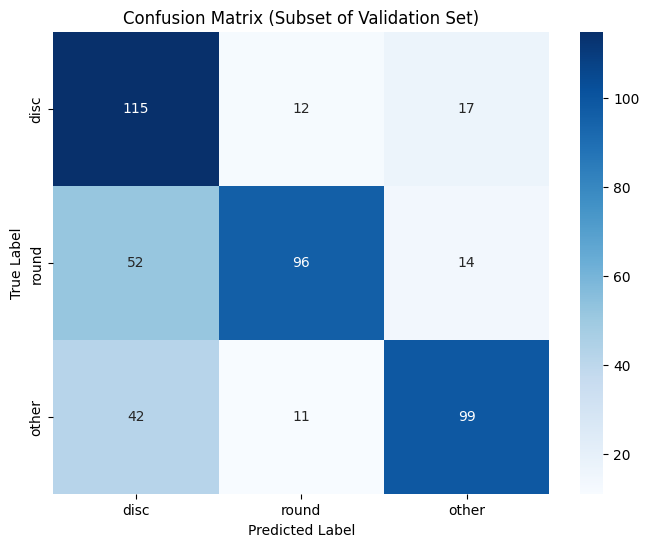

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the validation set
valid_generator.reset()
predictions = model.predict(valid_generator, steps=len(valid_generator), verbose=1)

# Get true labels for only those which were found during valid_generator
f_true_labels = valid_data[valid_data['GalaxyID'].isin(valid_generator.filenames)][['disc', 'spiral', 'elliptical', 'round', 'other']].values
true_labels = np.argmax(f_true_labels, axis=1)  # Convert each row of f_true_labels to numeric label

# Convert predictions to class labels
predicted_labels = predictions.argmax(axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print classification report
print(classification_report(true_labels, predicted_labels))

# Display seaborn heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['disc','round', 'other'], yticklabels=['disc', 'round', 'other'])
plt.title('Confusion Matrix (Subset of Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
